Aqui eu importo as bibliotecas utilizadas, instancio o objeto para a regressão linear e obtenho o dataframe a partir da base salva no meu Drive.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from ast import Lambda
from sklearn.linear_model import LinearRegression
rl = LinearRegression()
df = pd.read_csv('/content/drive/MyDrive/Tópicos/base_pesquisas_eleitorais.zip')


A base escolhida é fornecida pelo grupo de comunicação Poder360, e se trata de dados de pesquisas eleitorais compilados pelo mesmo. Segue o link para a base: https://basedosdados.org/dataset/br-poder360-pesquisas?bdm_table=microdados

A base abrange as pesquisas eleitorais para as eleições de 2000 até 2022, porém nessa análise optei pelas pesquisas para 2022.


In [ ]:
df

,id_pesquisa,ano,sigla_uf,nome_municipio,cargo,data,data_referencia,instituto,contratante,orgao_registro,...,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,3881,2000,RJ,Campos dos Goytacazes,prefeito,2000-01-01,jan/00,Brasmarket,NaN,NaN,...,estimulada,1,votos totais,10065,Diversos candidatos,2219,Claudeci,NaN,0,21.0
1,3881,2000,RJ,Campos dos Goytacazes,prefeito,2000-01-01,jan/00,Brasmarket,NaN,NaN,...,estimulada,1,votos totais,10065,Diversos candidatos,1996,Arnaldo Viana,PDT,0,47.0
2,3881,2000,RJ,Campos dos Goytacazes,prefeito,2000-01-01,jan/00,Brasmarket,NaN,NaN,...,estimulada,1,votos totais,10065,Diversos candidatos,1273,Paulo Feijó,PMDB,0,10.0
3,3881,2000,RJ,Campos dos Goytacazes,prefeito,2000-01-01,jan/00,Brasmarket,NaN,NaN,...,estimulada,1,votos totais,10066,Diversos candidatos,4227,Rockefeler,NaN,0,4.0
4,3881,2000,RJ,Campos dos Goytacazes,prefeito,2000-01-01,jan/00,Brasmarket,NaN,NaN,...,estimulada,1,votos totais,10066,Diversos candidatos,1541,Sem candidato,NaN,1,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132598,9768,2022,NaN,NaN,presidente,2021-12-21,19-21.dez.2021,PoderData,NaN,NaN,...,estimulada,2,votos totais,24697,cenário 5 - estimulado - 2º turno,1583,Sergio Moro,Podemos,0,30.0
132599,9768,2022,NaN,NaN,presidente,2021-12-21,19-21.dez.2021,PoderData,NaN,NaN,...,estimulada,2,votos totais,24698,cenário 6 - estimulado - 2º turno,289,Ciro,PDT,0,19.0
132600,9768,2022,NaN,NaN,presidente,2021-12-21,19-21.dez.2021,PoderData,NaN,NaN,...,estimulada,2,votos totais,24698,cenário 6 - estimulado - 2º turno,5046,não sabe,NaN,1,3.0
132601,9768,2022,NaN,NaN,presidente,2021-12-21,19-21.dez.2021,PoderData,NaN,NaN,...,estimulada,2,votos totais,24698,cenário 6 - estimulado - 2º turno,973,Lula,PT,0,50.0


Como podemos ver, a base possui mais de 130 mil linhas e 24 colunas.
As colunas utilizadas serão a de Data, que apresenta a data de determinada pesquisa, e a coluna de Percentuais, que apresenta o percentual de votos previsto para o respectivo candidato.
Pelo fato das datas estarem no formato yyyy/mm/dd, será necessário convertê-las para um formato que apresente o n° de dias contados a partir do dia inicial, que aqui se trata do primeiro dia das pesquisas para 2022, 18/08/2019. Essa conversão se faz necessária pois será utilizado o algoritmo de Regressão Linear, que necessita que os dados estejam organizados de forma linear e ordenada.



> Aqui eu faço um array com todas as datas do período de pesquisas para as eleições de 2022, para que seja possível localizar a data equivalente baseado no n° de dias contados.



In [ ]:
test_date = dt.datetime(2019, 8, 18)
K = 857
res = [test_date + dt.timedelta(days=idx) for idx in range(K)]
datas =  list(str(val)[:10] for val in res)




> Aqui eu faço algumas funções de formatação de datas, pois as datas não estão ordenadas no dataframe, então terei de converter elas para inteiro



In [ ]:
#se o numero for de apenas um digito, adiciona um zero na frente
def converterData(data):
  if len(str(data)) == 1:
    return '0'+str(data)
  else:
    return str(data)

#funcao para colocar as listas com as datas ordenadas no formato de data
def formatarDatas(datas):
  for i in range(len(datas)):
    for j in range(len(datas[i])):
      datas[i][j] = converterData(datas[i][j])


  for i in range(len(datas)):
    datas[i] = '-'.join(datas[i])

  return datas


#funcao para calcular o n° de dias de acordo com a data inicial das pesquisas para 2022: '2019-08-18'
def calcularDias(data):

  # Data final
  d2 = datetime.strptime(data, '%Y-%m-%d')
  # Data inicial
  d1 = datetime.strptime('2019-08-18', '%Y-%m-%d')


  return abs((d2 - d1).days)

#função que calcula a data equivalente de acordo com o nº de dias contados a partir de 2019-08-18
def dataEquivalente(dias):
  for i in datas:
    if calcularDias(i) == dias:
      return i
  return "Data não encontrada!"




> Aqui eu faço uma função para preparar um dataframe para a Regressão Linear, de acordo com o candidato e o turno escolhido



In [ ]:
def prepararDados(turno, candidato):
  df2022 = df[df['nome_candidato'] == candidato][df['ano'] == 2022] 
  df_turno = df2022[df2022['turno'] == turno]
  datas = df_turno['data'].unique() 
  


  datas_sort = []

  for i in datas:
    datas_sort.append(i.split('-')) 

  #colocando as datas em inteiro para ordená-las
  for i in range(len(datas_sort)):
    datas_sort[i] = list(int(val) for val in datas_sort[i]) 


  datas_2019 , datas_2020, datas_2021 = [], [], []

  #separando as datas de acordo com o ano
  for i in datas_sort:
    if i[0] == 2019:
      datas_2019.append(i)
    elif i[0] == 2020:
      datas_2020.append(i)
    else:
      datas_2021.append(i)


  #ordenando valores de acordo com o mês
  datas_2019 = sorted(datas_2019, key = lambda x:x[1])
  datas_2020 = sorted(datas_2020, key = lambda x:x[1])
  datas_2021 = sorted(datas_2021, key = lambda x:x[1])

  datas_2019 = formatarDatas(datas_2019)
  datas_2020 = formatarDatas(datas_2020)
  datas_2021 = formatarDatas(datas_2021)

  datas_em_dias = []

  for i in [datas_2019, datas_2020, datas_2021]:
    for j in i:
      datas_em_dias.append(calcularDias(j))
    

  datas_em_dias_sorted = []

  for i in range(len(df_turno['data'])):
    for j in datas_em_dias:
      if calcularDias(df_turno['data'].iloc[i]) == j:
          datas_em_dias_sorted.append(j)



  dfPreparado = {
      'Data': datas_em_dias_sorted,
      'Percentual': list(df_turno['percentual'])
  }

  dfPreparado = pd.DataFrame(dfPreparado).sort_values('Data')
  return dfPreparado

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Correlação entre a data e o percentual: -0.679638606061951


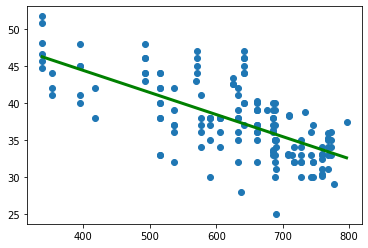

In [ ]:
dfPreparado = prepararDados(2 ,'Bolsonaro')
dfPreparado = dfPreparado.loc[(dfPreparado['Data'] > 300), ['Data', 'Percentual']]
dfPreparado = dfPreparado.loc[(dfPreparado['Data'] < 800), ['Data', 'Percentual']]
x, y = dfPreparado['Data'], dfPreparado['Percentual']
x_reshape = x.values.reshape(-1, 1)
y_flatten = y.values.flatten()
rl.fit(x_reshape, y_flatten)
plt.scatter(x, y)
x_arr = np.array(x_reshape).reshape(-1,1)
y_pred  = rl.predict(x_arr)
plt.plot(x_arr.flatten(), y_pred.flatten(), 'g',linewidth=3)
corr = dfPreparado['Percentual'].corr(dfPreparado['Data'])
print("Correlação entre a data e o percentual:", corr)

Acima eu fiz uma predição tendo como variável independente a data naquele formato de dias contados já mencionado, e variável dependente os percentuais das pesquisas para 2º Turno para o candidato Jair Bolsonaro. A correlação entre as variáveis aqui é expressiva.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Correlação entre a data e o percentual: 0.3346024696199348


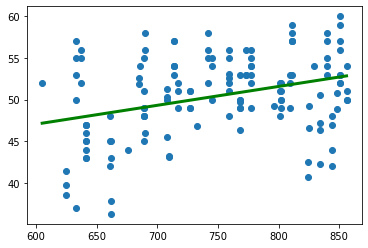

In [ ]:
dfPreparado = prepararDados(2,'Lula')
dfPreparado = dfPreparado.loc[(dfPreparado['Data'] > 600), ['Data', 'Percentual']]
x, y = dfPreparado['Data'], dfPreparado['Percentual']
x_reshape = x.values.reshape(-1, 1)
y_flatten = y.values.flatten()
rl.fit(x_reshape, y_flatten)
x_arr = np.array(x_reshape).reshape(-1,1) #prepara para o formato adequado
y_pred  = rl.predict(x_arr) #calcula a predição
plt.scatter(x, y)
corr = dfPreparado['Percentual'].corr(dfPreparado['Data'])
print("Correlação entre a data e o percentual:", corr)
plt.plot(x_reshape.flatten(), y_pred.flatten(), 'g',linewidth=3)

Acima eu fiz o mesmo que no passo anterior porém para o candidato Lula. Como se pode ver, a correlação aqui não é tão alta quanto na predição anterior.

Em ambas as predições o intervalo de datas foi cortado para que a predição fosse mais precisa.

Se analisarmos as retas das duas regressões lineares feitas veremos que os gráficos condizem bastante com o resultado das eleições, afinal os percentuais do Bolsonaro começam altos e vão diminuindo, já no gráfico do candidato Lula ocorre o contrário, este último vencedor das eleições no segundo turno.